# Overview

This notebook introduces the planar drone example used throughout the course. The notebook is broken up into the following sections:

1. Install and Import Packages
2. Planar Drone Dynamics
3. Open and Closed Loop Dynamics Simulations
4. Model Predictive Control of Planar Drone
5. Saving Trajectory as a Pandas Dataframe
6. Exercises
7. Next Steps
8. Reusable Functions

# 1.&nbsp;Install and Import Packages

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
try:
    import nonlinear_estimation_utilities
    print('Package ' + 'nonlinear_estimation_utilities' + ' is already installed.')
    nonlinear_estimation_utilities.check_for_updates()
except:
    !pip install -qq git+https://github.com/florisvb/Nonlinear_and_Data_Driven_Estimation && echo "✓ nonlinear_estimation_utilities installed"
    import nonlinear_estimation_utilities
    nonlinear_estimation_utilities.check_for_updates()

  Preparing metadata (setup.py) ... done
✓ nonlinear_estimation_utilities installed
✓ You have the latest version (0.0.32)


In [3]:
nonlinear_estimation_utilities.install_and_download_requirements.install_planar_drone_requirements()

Attempting to pip install: casadi
Attempting to pip install: do_mpc
Attempting to pip install: git+https://github.com/vanbreugel-lab/pybounds
Attempting to pip install: pynumdiff


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint

In [5]:
import pybounds

# 2.&nbsp;Planar drone dynamics

See notes for derivation. Here we organize the dynamics into control affine form so that it is easy to see how each control input influences all of the states.

Throughout the course we use the following definitions and color codes:

* $\bbox[yellow]{\text{Dynamic states}}$: state variables that change in time.
* $\bbox[pink]{\text{Static states}}$: state variables that are constant in time (i.e. their derivative is zero).
* $\bbox[lightblue]{\text{Parameters}}$: variables that represent known constant values. Distinct from static states in that these variables do not appear in the state vector.
* $\bbox[lightgreen]{\text{Control inputs}}$: variables that influence the behavior of the system that are under our control.

Every variable in both the dynamics and measurement equations must fall into one of the four categories above. Only dynamic and static states will be accessible to the estimator that we design later in the course.

$\bbox[red]{\text{TODO}}$: Add free body diagram of the drone.

## Planar drone dynamics equation

$
\mathbf{\dot{x}} = \mathbf{f}(\mathbf{x},\mathbf{u}) =
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[yellow]{x} \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
\bbox[pink]{k}
\end{bmatrix} =
\overset{f_0}{\begin{bmatrix}
\bbox[yellow]{\dot{\theta}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{x}} \\[0.3em]
0 \\[0.3em]
\bbox[yellow]{\dot{z}} \\[0.3em]
-\bbox[lightblue]{g} \\[0.3em]
0
\end{bmatrix}} +
\overset{f_1}{\begin{bmatrix}
0 \\[0.3em]
\bbox[lightblue]{l}\bbox[pink]{k}/\bbox[lightblue]{I_{yy}} \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_1} +
\overset{f_2}{\begin{bmatrix}
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
-\bbox[pink]{k}\bbox[yellow]{\sin\theta}/\bbox[lightblue]{m} \\[0.3em]
0 \\[0.3em]
\bbox[pink]{k}\bbox[yellow]{\cos\theta}/\bbox[lightblue]{m}  \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{j_2}
$

<span style="color:blue;">AI tip: try an LLM to convert picture of your dynamics to latex. It'll get much of it right, but you may need to fix it.

## Planar drone measurement equation

Define a measurement function. In this case we consider $\mathbf{y}$ consisting of a downward facing camera that records ventral optic flow, and a measurement of the tilt of the planar drone. We will add more measurements later in the course.

$
\mathbf{y} =
\begin{bmatrix}
\bbox[yellow]{\dot{x}}/\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\theta}
\end{bmatrix}
$

## Set the values for constant parameters (the blue symbols above)

In [6]:
m = 1 # mass (kg)
g = 9.81 # acceleration due to gravity (m/s^2)
L = 0.5 # length of the drone arm (m)
Iyy = 0.02 # moment of inertia (e.g. 1/12*m*L**2 for a solid rod, as an approximation)

## Define the dynamics and measurement functions

We will use this same format $\bbox[yellow]{\mathbf{f}(\mathbf{x},\mathbf{u})}$ and $\bbox[yellow]{\mathbf{h}(\mathbf{x},\mathbf{u})}$ many times, for evaluating observability and Kalman filters.

<span style="color:blue;">AI tip: try an LLM to convert a picture of the dynamics, or the latex code, to a python function. You may have to correct it!

In [7]:
def f(x_vec, u_vec, m=m, g=g, L=L, I=Iyy):
    """
    Continuous time dynamics function for the system shown in the equation.

    Parameters:
    x_vec : array-like, shape (7,)
        State vector [θ, θ̇, x, ẋ, z, ż, k]
    u_vec : array-like, shape (2,)
        Control vector [j1, j2]
    L : float, default 0.5
        drone arm length
    m : float, default 1.0
        drone mass
    g : float, default 9.81
        Gravitational acceleration

    Returns:
    x_dot : numpy array, shape (7,)
        Time derivative of state vector
    """

    # Extract state variables
    theta = x_vec[0]
    theta_dot = x_vec[1]
    x = x_vec[2]
    x_dot = x_vec[3]
    z = x_vec[4]
    z_dot = x_vec[5]
    k = x_vec[6]

    # Extract control inputs
    j1 = u_vec[0]
    j2 = u_vec[1]

    # f0 component: drift dynamics (no controls)
    f0_contribution = np.array([ theta_dot,
                                 0,
                                 x_dot,
                                 0,
                                 z_dot,
                                 -g / m,
                                 0])

    # f1 component: multiplied by control j1
    f1_contribution = j1 * np.array([0,
                                     L*k/Iyy,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0])

    # f2 component: multiplied by control j2
    f2_contribution = j2 * np.array([0,
                                     0,
                                     0,
                                     -k * np.sin(theta) / m,
                                     0,
                                     k * np.cos(theta) / m,
                                     0])

    # combined dynamics
    x_dot_vec = f0_contribution + f1_contribution + f2_contribution

    return x_dot_vec

In [8]:
def h(x_vec, u_vec):
    """
    Discrete time measurement function for the planar drone.

    Parameters:
    x_vec : array-like, shape (7,)
        State vector [θ, θ̇, x, ẋ, z, ż, k]
    u_vec : array-like, shape (2,)
        Control vector [j1, j2]

    Returns:
    y : numpy array, shape (2,)
        Measurement vector
    """
    # Extract state variables
    theta = x_vec[0]
    theta_dot = x_vec[1]
    x = x_vec[2]
    x_dot = x_vec[3]
    z = x_vec[4]
    z_dot = x_vec[5]
    k = x_vec[6]

    # Extract control inputs
    j1 = u_vec[0]
    j2 = u_vec[1]

    # Measurements
    y_vec = [x_dot/z, theta]

    # Return measurement
    return y_vec

# 3.&nbsp;Open and closed loop dynamics simulations with `odeint`

To generate a trajectory with our dynamics function we can integrate it using `odeint`. To use `odeint` we need to wrap our dynamics function to be compatible with the `odeint` format.

In [9]:
def f_ode(x_vec, tsim, u_func, f):
    '''
    Wrap dynamics function so it can be used with odeint.

    Parameters:
    x_vec : array-like, shape (7,)
        State vector
    tsim : float
        Current time step
    u_func: function
        Control function
    f: function
        Continuous time dynamics function

    Returns:
    x_dot_vec : numpy array, shape (7,)
        Time derivative of state vector
    '''
    u_vec = u_func(x_vec, tsim)
    x_dot_vec = f(x_vec, u_vec)
    return x_dot_vec

## Open loop simulation

To generate a simple trajectory with open loop (pre-determined) control inputs we can prespecify the controls.

In [10]:
def u_func_open_loop(x_vec, tsim):
    '''
    Simple open loop control function that aims to move the drone up, and make the angle oscillate slightly.
    '''
    # control inputs only depend on time
    u = [0.01*np.cos(tsim), # j1: controls the angular velocity of the drone, oscillate it
      m*g*1.2] # j2: controls the thrust, make it slightly more than weight support

    return u

In [11]:
# sim time
dt = 0.01
tsim = np.arange(0, 8.0, step=dt)

# initial condition
x0 = np.array([0, 0, 0, 0, 10, 0, 1])

In [12]:
# run odeint
result = odeint(f_ode, x0, tsim, args=(u_func_open_loop, f) )

### Plot the results

The result of the simulation is an array with:
* rows correspond to time
* columns correspond to state values

We can plot the angle $\theta$ over time, and a plot of the position of the drone in the $x,z$ plane to see its behavior.

Text(0, 0.5, 'z pos')

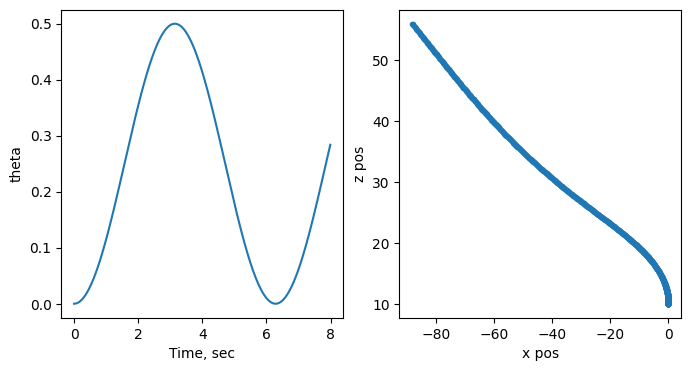

In [13]:
fig = plt.figure(figsize=(8,4))

ax1 = fig.add_subplot(121)

ax1.plot(tsim, result[:,0])
ax1.set_xlabel('Time, sec')
ax1.set_ylabel('theta')

ax2 = fig.add_subplot(122)

ax2.plot(result[:,2], result[:,4], '.')
ax2.set_xlabel('x pos')
ax2.set_ylabel('z pos')

## Close loop simulation

To get better control of the drone we can replace the control function with something that uses the current state. For example, we can implement a simple proportional controller to try and stabilize the drone.

In [14]:
def u_func_closed_loop(x_vec, tsim, m=m, g=g, L=L, Iyy=Iyy):
    '''
    Simple proportional controller that aims to move the drone up, and make the angle oscillate.
    '''
    theta = x_vec[0]
    theta_des = np.sin(2*tsim)*0.1
    err = theta_des - theta
    ctrl = 10*err
    return [ctrl, m*g*1.2]

In [15]:
# sim time
dt = 0.01
tsim = np.arange(0, 8.0, step=dt)

# initial condition
x0 = np.array([0, 0, 0, 0, 10, 0, 1])

In [16]:
# run odeint
result = odeint(f_ode, x0, tsim, args=(u_func_closed_loop, f) )

### Plot the results

The result of the simulation is an array with:
* rows correspond to time
* columns correspond to state values

We can plot the angle $\theta$ over time, and a plot of the position of the drone in the $x,z$ plane to see its behavior.

Text(0, 0.5, 'z pos')

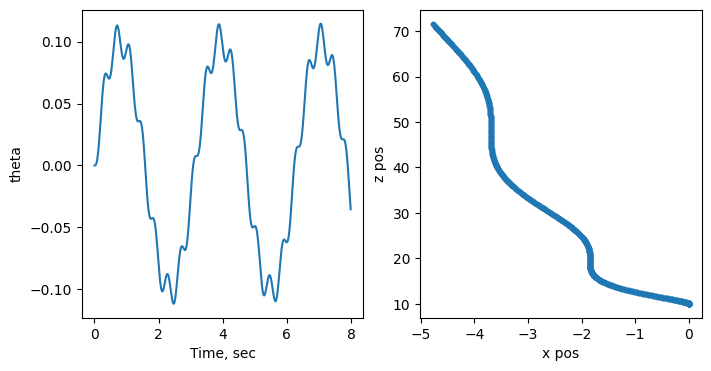

In [17]:
fig = plt.figure(figsize=(8,4))

ax1 = fig.add_subplot(121)

ax1.plot(tsim, result[:,0])
ax1.set_xlabel('Time, sec')
ax1.set_ylabel('theta')

ax2 = fig.add_subplot(122)

ax2.plot(result[:,2], result[:,4], '.')
ax2.set_xlabel('x pos')
ax2.set_ylabel('z pos')

# 4.&nbsp;Model Predictive Control of Planar Drone

Because it is difficult to control the nonlinear dynamics of our planar drone, and because it is unstable without any control, we will simplify the task of driving it along a trajectory by using Model Predicitive Control (MPC).

We will use the `pybounds` simulator environment to wrap MPC functions to simplify the interface.

## Specify state, control, and measurement names

In [18]:
state_names = ['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot', 'k']
input_names = ['j1', 'j2']
measurement_names = ['optic_flow', 'theta']

## Define the `pybounds` simulator object

For this MPC approach we use a longer dt than the odeint approach.

In [19]:
# set the time step
dt = 0.1

# create the simulator
simulator = pybounds.Simulator(f, h, # f and h functions, format must be f(x,u)
                               dt=dt, # use a longer time step than with odeint
                               state_names=state_names,
                               input_names=input_names,
                               measurement_names=measurement_names,
                               mpc_horizon=int(1/dt)) # 1 second horizon

## Define the desired trajectory and cost function for MPC



### Define the desired trajectory

In [20]:
# First define the set-point(s) to follow
tsim = np.arange(0, 8.0, step=dt)
NA = np.zeros_like(tsim)
setpoint = {'theta': NA,
            'theta_dot': NA,
            'x': 1.0*np.cos(2*np.pi*tsim*0.3),  # ground speed changes as a sinusoid
            'x_dot': NA,
            'z': 0.3*np.sin(2*np.pi*tsim*0.2)+0.5, # altitude also oscillates
            'z_dot': NA,
            'k': np.ones_like(tsim), # constant values of 1
           }

# Update the simulator set-point
simulator.update_dict(setpoint, name='setpoint')

### Define the cost function

In [21]:
# Define MPC cost function: penalize the squared error between the setpoint for g and the true g
cost_x = (simulator.model.x['x'] - simulator.model.tvp['x_set']) ** 2
cost_z = (simulator.model.x['z'] - simulator.model.tvp['z_set']) ** 2
cost = cost_x + cost_z

# Set cost function
simulator.mpc.set_objective(mterm=cost, lterm=cost)  # objective function

# Set input penalty: make this small for accurate state tracking
simulator.mpc.set_rterm(j1=1e-4, j2=1e-4)

### Set some bounds

In [22]:
simulator.mpc.bounds['lower', '_x', 'theta'] = -np.pi/4
simulator.mpc.bounds['upper', '_x', 'theta'] = np.pi/4
simulator.mpc.bounds['lower', '_x', 'z'] = 0.0

simulator.mpc.bounds['lower', '_u', 'j2'] = 0.0

## Run the MPC and look at the results

In [23]:
# Run simulation using MPC
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, u=None, mpc=True, return_full_output=True)

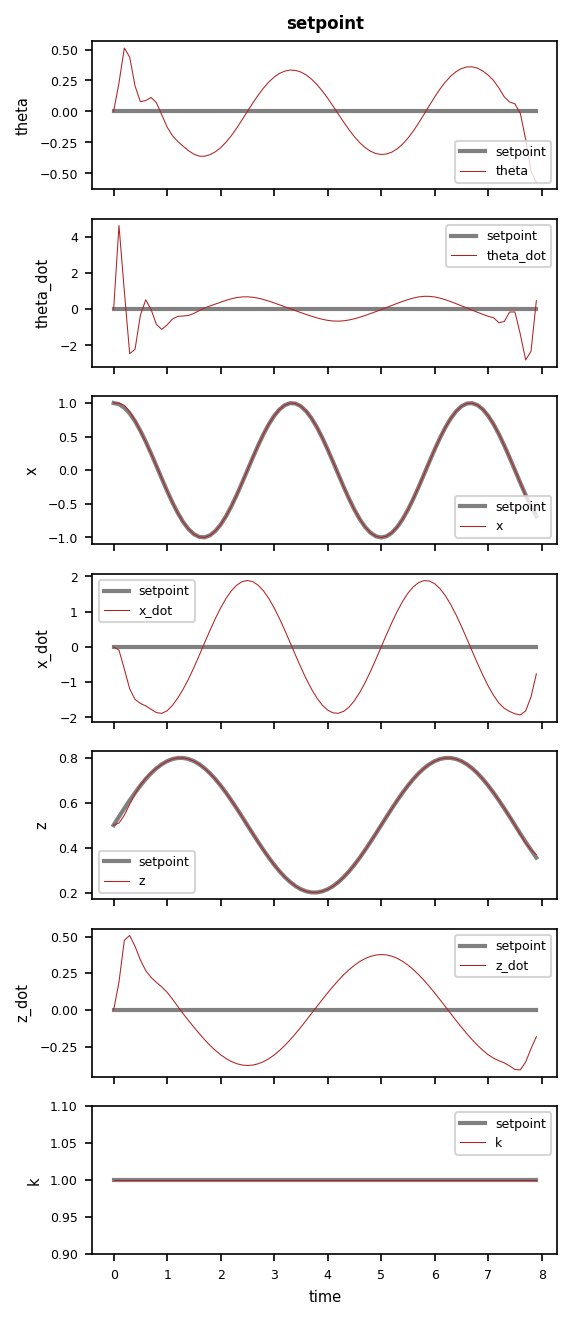

In [24]:
simulator.plot('setpoint')

#5.&nbsp;Save the trajectory to pandas dataframe

This makes is easy to load in a future notebook, for example `B_planar_drone_animation.ipynb`

We will use pandas dataframes and hdf files throughout the course. This serves as a brief introduction.

In [25]:
# turn all the sim outputs into pandas dataframes
df_x = pd.DataFrame(x_sim) # x_sim is a dict
df_u = pd.DataFrame(u_sim) # u_sim is a dict
df_y = pd.DataFrame(y_sim) # y_sim is a dict
df_t = pd.DataFrame({'time': t_sim}) # t_sim is a 1d array, make it a dict

# rename the columns for y so that they do not conflict with state names
new_names = {key: 'sensor_' + key for key in df_y}
df_y = df_y.rename(columns=new_names)

# merge into a single data frame for the entire trajectory
df_trajec = pd.concat([df_t, df_x, df_u, df_y], axis=1)

# save the dataframe so we can use it later
df_trajec.to_hdf('planar_drone_sim_states.hdf', key='trajectory')

## Look at the dataframe format

In [26]:
df_trajec

,time,theta,theta_dot,x,x_dot,z,z_dot,k,j1,j2,sensor_optic_flow,sensor_theta
0,0.0,0.000000,0.000000,1.000000,0.000000,0.500000,0.000000,1.0,1.848860,11.776317,0.000000,0.000000
1,0.1,0.231107,4.622149,0.997736,-0.090374,0.509727,0.190357,1.0,-1.450777,13.798740,-0.177299,0.231107
2,0.2,0.511975,0.995208,0.964789,-0.628196,0.544222,0.475047,1.0,-1.379203,11.581533,-1.154302,0.511975
3,0.3,0.439096,-2.452800,0.873379,-1.187611,0.593028,0.507733,1.0,0.096904,9.576972,-2.002622,0.439096
4,0.4,0.205929,-2.210539,0.737804,-1.488634,0.639508,0.433607,1.0,0.750186,8.961957,-2.327780,0.205929
...,...,...,...,...,...,...,...,...,...,...,...,...
75,7.5,0.061083,-0.150447,0.002942,-1.896770,0.499276,-0.404995,1.0,-0.492655,9.792643,-3.799036,0.061083
76,7.6,-0.015544,-1.382085,-0.188977,-1.929105,0.458633,-0.407515,1.0,-0.568378,10.424573,-4.206206,-0.015544
77,7.7,-0.224800,-2.803030,-0.378067,-1.816612,0.420758,-0.354071,1.0,0.190491,11.473235,-4.317469,-0.224800
78,7.8,-0.481291,-2.326803,-0.542030,-1.416741,0.390755,-0.263041,1.0,1.120153,12.477465,-3.625652,-0.481291


## Download the saved hdf file

You can find it here. Hover over the filename, click the three dots and download it so that you can upload to another notebook instance.

<img src="https://github.com/florisvb/Nonlinear_and_Data_Driven_Estimation/blob/main/images/colab_notebook_files.png?raw=1" alt="notebook files" width="600"/>

You can also connect colab to a google drive where you can save data and access it from any notebook.

For the course, many of the datasets we need are saved in the course repository under `Data` and `Trained_Models` so that they are easy to access.

#6.&nbsp;Exercises

1. Update the dynamics model to include air drag ($Drag = C*vel^2$, where C is a combined drag coefficient, traditionally $C=1/2 \rho C_d A$).
    * Does this make it "easier" or "harder" to control the drone?
2. Adjust the desired (setpoint) trajectory.
    * Question: What is the fastest you can make the drone oscillate in the x dimension?
3. Change the `rterm` in `simulator.mpc.set_rterm(j1=1e-4, j2=1e-4)` of the MPC section?
    * Question: How does the trajectory of the drone change as you increase the `rterm`?

#7.&nbsp;Next steps
1. Loading saved data
2. Making an animation
3. Use this model and trajectory to analyze observability and write a Kalman filter to estimate states given limited measurements.

# 8.&nbsp;Reusable functions

We will reuse the planar drone model throughout the subsequent notebooks. To keep our notebooks organized the dynamics functions and simulator functions are wrapped into utility functions in `nonlinear_estimation_utilities.planar_drone`, with a little extra functionality.

To use these utility functions we first need to load the modules. Note that to load these modules you first have to have run `nonlinear_estimation_utilities.install_planar_drone_requirements()`, which we ran at the top of the notebook.

In [ ]:
# load the plotting and planar drone modules
nonlinear_estimation_utilities.load_planar_drone_modules()
nonlinear_estimation_utilities.load_plotting_modules()

# simplify syntax
planar_drone = nonlinear_estimation_utilities.planar_drone
plot_utility = nonlinear_estimation_utilities.plot_utility

## Extract the dynamics and measurement functions.

These operate identically to the ones defined above in this notebook. The functions in this planar_drone module have a little extra functionality.

* `nonlinear_estimation_utilities.planar_drone.F().f()`: dynamics of planar drone
* `nonlinear_estimation_utilities.planar_drone.H('h_camera_imu).h()`: measurements of planar drone

In [ ]:
# extract the dynamics function
f = planar_drone.F().f

# extract the measurement function -- the string determines which measurement function to
h = planar_drone.H('h_camera_imu').h

## Simulate, package, and plot a drone trajectory

Simulate a "squiggle" trajectory which oscillates in the x and z dimensions, using the MPC framework developed above. Package into a pandas dataframe, and plot it.

* `nonlinear_estimation_utilities.planar_drone.simulate_drone()`: simulate a drone trajectory with MPC
* `nonlinear_estimation_utilities.planar_drone.package_data_as_pandas_dataframe()`: package simulation as a nice pandas dataframe
* `nonlinear_estimation_utilities.plot_utility.plot_planar_drone()`



(<Axes: xlabel='Time, sec', ylabel='theta'>,
 <Axes: xlabel='x pos', ylabel='z pos'>)

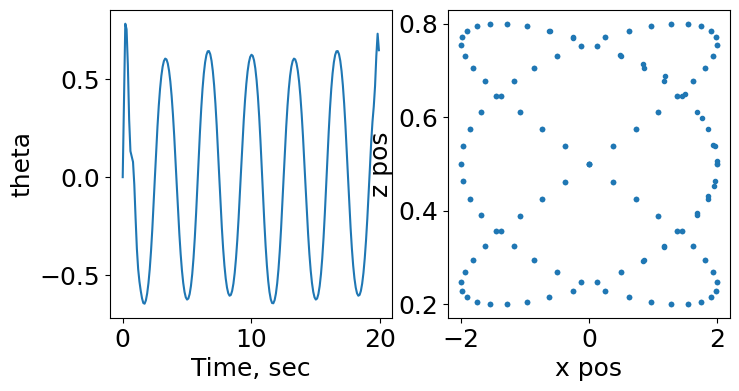

In [ ]:
# simulate the trajectory
t_sim, x_sim, u_sim, y_sim, simulator = planar_drone.simulate_drone(f, h, trajectory_shape='squiggle')

# package into a pandas dataframe
df_trajec = planar_drone.package_data_as_pandas_dataframe(t_sim, x_sim, u_sim, y_sim)

# plot the angle and x,z trajectory
plot_utility.plot_planar_drone(df_trajec)